# Sentiment Analysis with IMDB Movie Reviews

## Overview
This notebook implements a comprehensive sentiment analysis model using the IMDB Movie Reviews dataset. I'll explore various machine learning and deep learning approaches to classify movie reviews as positive or negative sentiment.

## Dataset
- **Source**: IMDB Dataset.csv containing 50,000 movie reviews
- **Features**: Review text and sentiment labels (positive/negative)
- **Task**: Binary classification for sentiment prediction
- **Applications**: Review analysis, content moderation, customer feedback analysis

## Approach
1. **Data Exploration**: Understanding the dataset structure and characteristics
2. **Text Preprocessing**: Cleaning, tokenization, and feature extraction
3. **Feature Engineering**: TF-IDF, word embeddings, and text statistics
4. **Model Implementation**: Multiple approaches including traditional ML and deep learning
5. **Model Evaluation**: Performance comparison and analysis
6. **Visualization**: Results interpretation and insights


In [9]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow nltk wordcloud plotly



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Available GPUs: {len(tf.config.experimental.list_physical_devices('GPU'))}")


Libraries imported successfully!
TensorFlow version: 2.20.0
Available GPUs: 0


[nltk_data] Downloading package wordnet to /Users/mmesoma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mmesoma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading and Exploration

Let me start by loading and exploring the IMDB movie reviews dataset to understand its structure and characteristics.


In [11]:
# Load the IMDB dataset
df = pd.read_csv('../datasets/IMDB Dataset.csv')

# Basic information about the dataset
print("=== IMDB Movie Reviews Dataset Overview ===")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn information:")
print(df.info())
print("\nFirst few rows:")
df.head()


=== IMDB Movie Reviews Dataset Overview ===
Dataset shape: (50000, 2)
Memory usage: 68.46 MB

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

First few rows:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


=== Data Quality Check ===
Missing values:
review       0
sentiment    0
dtype: int64

Duplicate reviews: 418
Duplicate review texts: 418

=== Sentiment Distribution ===
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Percentage distribution:
sentiment
positive    50.0
negative    50.0
Name: count, dtype: float64


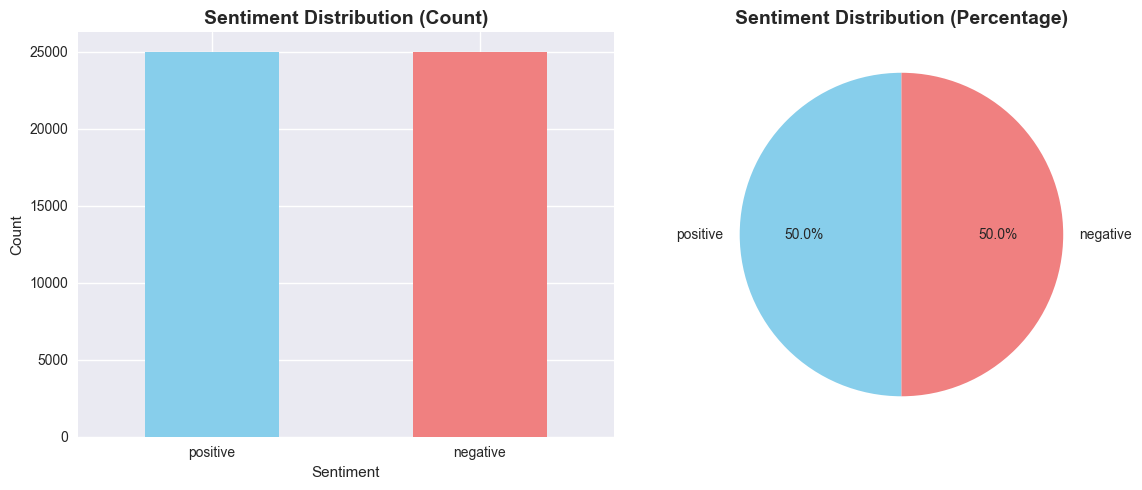

In [12]:
# Check for missing values and duplicates
print("=== Data Quality Check ===")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate reviews: {df.duplicated().sum()}")
print(f"Duplicate review texts: {df['review'].duplicated().sum()}")

# Sentiment distribution
print(f"\n=== Sentiment Distribution ===")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"\nPercentage distribution:")
print(sentiment_counts / len(df) * 100)

# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sentiment_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.set_xticklabels(sentiment_counts.index, rotation=0)

# Pie chart
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral'], startangle=90)
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


=== Review Text Analysis ===

Review length statistics (characters):
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64

Word count statistics:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64

Sentence count statistics:
count    50000.000000
mean        14.010400
std          9.890968
min          1.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        176.000000
Name: sentence_count, dtype: float64


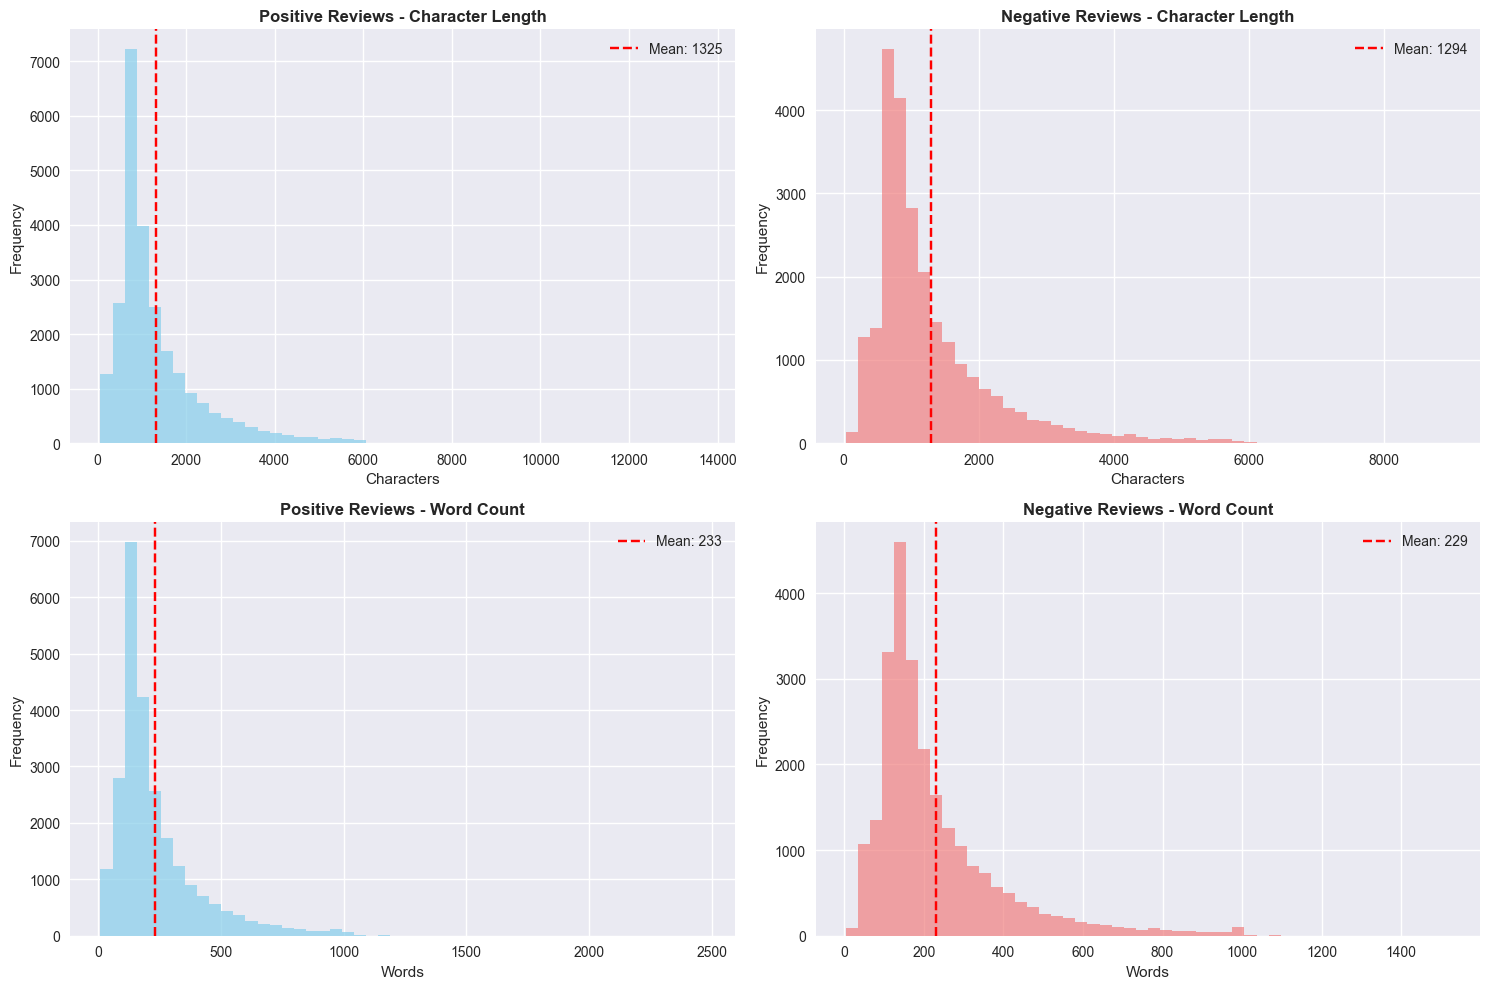


=== Sentiment Comparison ===
Review Length:
  Positive: 1324.8
  Negative: 1294.1
  Difference: 30.7

Word Count:
  Positive: 232.8
  Negative: 229.5
  Difference: 3.4

Sentence Count:
  Positive: 13.7
  Negative: 14.4
  Difference: 0.7



In [13]:
# Analyze review lengths and characteristics
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()
df['sentence_count'] = df['review'].str.split('.').str.len()

print("=== Review Text Analysis ===")
print("\nReview length statistics (characters):")
print(df['review_length'].describe())
print("\nWord count statistics:")
print(df['word_count'].describe())
print("\nSentence count statistics:")
print(df['sentence_count'].describe())

# Visualize text characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Review length by sentiment
for i, sentiment in enumerate(['positive', 'negative']):
    subset = df[df['sentiment'] == sentiment]
    
    axes[0, i].hist(subset['review_length'], bins=50, alpha=0.7, 
                   color='skyblue' if sentiment == 'positive' else 'lightcoral')
    axes[0, i].set_title(f'{sentiment.title()} Reviews - Character Length', fontweight='bold')
    axes[0, i].set_xlabel('Characters')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].axvline(subset['review_length'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {subset["review_length"].mean():.0f}')
    axes[0, i].legend()

# Word count by sentiment
for i, sentiment in enumerate(['positive', 'negative']):
    subset = df[df['sentiment'] == sentiment]
    
    axes[1, i].hist(subset['word_count'], bins=50, alpha=0.7, 
                   color='skyblue' if sentiment == 'positive' else 'lightcoral')
    axes[1, i].set_title(f'{sentiment.title()} Reviews - Word Count', fontweight='bold')
    axes[1, i].set_xlabel('Words')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].axvline(subset['word_count'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {subset["word_count"].mean():.0f}')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

# Statistical comparison between sentiments
print("\n=== Sentiment Comparison ===")
for metric in ['review_length', 'word_count', 'sentence_count']:
    pos_mean = df[df['sentiment'] == 'positive'][metric].mean()
    neg_mean = df[df['sentiment'] == 'negative'][metric].mean()
    print(f"{metric.replace('_', ' ').title()}:")
    print(f"  Positive: {pos_mean:.1f}")
    print(f"  Negative: {neg_mean:.1f}")
    print(f"  Difference: {abs(pos_mean - neg_mean):.1f}")
    print()


In [14]:
# Sample reviews from each sentiment
print("=== Sample Reviews ===")
print("\n" + "="*60)
print("POSITIVE REVIEW EXAMPLE:")
print("="*60)
pos_sample = df[df['sentiment'] == 'positive']['review'].iloc[0]
print(pos_sample[:500] + "..." if len(pos_sample) > 500 else pos_sample)

print("\n" + "="*60)
print("NEGATIVE REVIEW EXAMPLE:")
print("="*60)
neg_sample = df[df['sentiment'] == 'negative']['review'].iloc[0]
print(neg_sample[:500] + "..." if len(neg_sample) > 500 else neg_sample)

# Check for HTML tags and special characters
print(f"\n=== Text Quality Check ===")
html_tags = df['review'].str.contains('<.*?>', regex=True).sum()
print(f"Reviews with HTML tags: {html_tags} ({html_tags/len(df)*100:.1f}%)")

special_chars = df['review'].str.contains('[^a-zA-Z0-9\s.,!?;:\'"()-]', regex=True).sum()
print(f"Reviews with special characters: {special_chars} ({special_chars/len(df)*100:.1f}%)")

# Show some HTML tag examples
html_examples = df[df['review'].str.contains('<.*?>', regex=True)]['review'].head(2)
for i, example in enumerate(html_examples, 1):
    print(f"\nHTML Example {i}:")
    print(example[:200] + "..." if len(example) > 200 else example)


=== Sample Reviews ===

POSITIVE REVIEW EXAMPLE:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...

NEGATIVE REVIEW EXAMPLE:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguin

## Text Preprocessing

Before training any models, I need to clean and preprocess the text data to remove noise and standardize the format.


In [15]:
def preprocess_text(text):
    """
    Comprehensive text preprocessing function for sentiment analysis.
    
    Args:
        text (str): Raw text to be processed
        
    Returns:
        str: Cleaned and processed text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Remove extra whitespace and normalize
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep punctuation that might be important for sentiment
    text = re.sub(r'[^a-zA-Z0-9\s.,!?;:\'"()-]', ' ', text)
    
    # Remove extra spaces
    text = text.strip()
    
    return text

def advanced_preprocess_text(text, remove_stopwords=True, apply_stemming=False, apply_lemmatization=True):
    """
    Advanced text preprocessing with optional stemming and lemmatization.
    
    Args:
        text (str): Text to preprocess
        remove_stopwords (bool): Whether to remove stopwords
        apply_stemming (bool): Whether to apply stemming
        apply_lemmatization (bool): Whether to apply lemmatization
        
    Returns:
        str: Processed text
    """
    # Basic preprocessing
    text = preprocess_text(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords if requested
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Keep important sentiment words
        sentiment_words = {'not', 'no', 'never', 'none', 'nothing', 'neither', 'nowhere', 'nobody'}
        stop_words = stop_words - sentiment_words
        tokens = [token for token in tokens if token.lower() not in stop_words]
    
    # Apply stemming
    if apply_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Apply lemmatization
    if apply_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove single characters and very short words
    tokens = [token for token in tokens if len(token) > 1]
    
    return ' '.join(tokens)

# Test the preprocessing functions
print("=== Text Preprocessing Examples ===")
sample_text = df['review'].iloc[0]
print("Original text (first 200 chars):")
print(sample_text[:200])
print("\nBasic preprocessing:")
print(preprocess_text(sample_text)[:200])
print("\nAdvanced preprocessing:")
print(advanced_preprocess_text(sample_text)[:200])


=== Text Preprocessing Examples ===
Original text (first 200 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo

Basic preprocessing:
one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was i

Advanced preprocessing:
one reviewer mentioned watching oz episode 'll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull n


In [16]:
# Apply preprocessing to the dataset
print("Applying preprocessing to the dataset...")
df['cleaned_review'] = df['review'].apply(preprocess_text)
df['processed_review'] = df['review'].apply(advanced_preprocess_text)

# Remove any empty reviews after preprocessing
print(f"Reviews before cleaning: {len(df)}")
df = df[df['processed_review'].str.len() > 0]
print(f"Reviews after cleaning: {len(df)}")

# Encode sentiment labels
df['sentiment_encoded'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("\n=== Preprocessing Complete ===")
print(f"Final dataset shape: {df.shape}")
print(f"Sample processed review:")
print(df['processed_review'].iloc[0][:300])


Applying preprocessing to the dataset...
Reviews before cleaning: 50000
Reviews after cleaning: 50000

=== Preprocessing Complete ===
Final dataset shape: (50000, 8)
Sample processed review:
one reviewer mentioned watching oz episode 'll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum s


## Feature Engineering and Data Splitting

Now I'll create features from the text data and split it into training and testing sets.


In [17]:
# Split the data into training and testing sets
X = df['processed_review']
y = df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=== Data Split Information ===")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training sentiment distribution:")
print(y_train.value_counts())
print(f"Testing sentiment distribution:")
print(y_test.value_counts())

# Create TF-IDF features for traditional ML models
print("\n=== Creating TF-IDF Features ===")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Feature names sample: {tfidf_vectorizer.get_feature_names_out()[:10]}")

# Create features for deep learning models
print("\n=== Preparing Data for Deep Learning ===")
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
max_length = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequence shape: {X_train_padded.shape}")
print(f"Max sequence length: {max_length}")

# Convert labels to numpy arrays for deep learning
y_train_dl = np.array(y_train)
y_test_dl = np.array(y_test)


=== Data Split Information ===
Training set size: 40000
Testing set size: 10000
Training sentiment distribution:
sentiment_encoded
1    20000
0    20000
Name: count, dtype: int64
Testing sentiment distribution:
sentiment_encoded
0    5000
1    5000
Name: count, dtype: int64

=== Creating TF-IDF Features ===
TF-IDF feature matrix shape: (40000, 10000)
Feature names sample: ['00' '000' '007' '10' '10 10' '10 line' '10 minute' '10 movie' '10 star'
 '10 year']

=== Preparing Data for Deep Learning ===
Vocabulary size: 88966
Padded sequence shape: (40000, 200)
Max sequence length: 200


## Traditional Machine Learning Models

I'll train and compare several traditional machine learning models using TF-IDF features.


In [18]:
# Initialize traditional ML models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store results
ml_results = {}

print("=== Training Traditional Machine Learning Models ===")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if y_pred_proba is not None:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    else:
        auc_score = None
    
    ml_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if auc_score:
        print(f"  AUC-ROC: {auc_score:.4f}")

print("\n=== Traditional ML Models Training Complete ===")

# Create results dataframe for comparison
ml_comparison = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Accuracy': [ml_results[model]['accuracy'] for model in ml_results.keys()],
    'Precision': [ml_results[model]['precision'] for model in ml_results.keys()],
    'Recall': [ml_results[model]['recall'] for model in ml_results.keys()],
    'F1-Score': [ml_results[model]['f1_score'] for model in ml_results.keys()],
    'AUC-ROC': [ml_results[model]['auc_score'] if ml_results[model]['auc_score'] else 0 
                for model in ml_results.keys()]
})

print("\n=== Model Performance Comparison ===")
print(ml_comparison.round(4))


=== Training Traditional Machine Learning Models ===

Training Logistic Regression...
  Accuracy: 0.8928
  Precision: 0.8836
  Recall: 0.9048
  F1-Score: 0.8941
  AUC-ROC: 0.9595

Training Multinomial Naive Bayes...
  Accuracy: 0.8621
  Precision: 0.8489
  Recall: 0.8810
  F1-Score: 0.8647
  AUC-ROC: 0.9345

Training Bernoulli Naive Bayes...
  Accuracy: 0.8590
  Precision: 0.8498
  Recall: 0.8722
  F1-Score: 0.8608
  AUC-ROC: 0.9267

Training Random Forest...
  Accuracy: 0.8526
  Precision: 0.8602
  Recall: 0.8420
  F1-Score: 0.8510
  AUC-ROC: 0.9306

Training Gradient Boosting...
  Accuracy: 0.8082
  Precision: 0.7731
  Recall: 0.8724
  F1-Score: 0.8198
  AUC-ROC: 0.8976

=== Traditional ML Models Training Complete ===

=== Model Performance Comparison ===
                     Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0      Logistic Regression    0.8928     0.8836  0.9048    0.8941   0.9595
1  Multinomial Naive Bayes    0.8621     0.8489  0.8810    0.8647   0.9345
2    Be

## Deep Learning Models

Now I'll implement neural network models using TensorFlow/Keras for sentiment analysis.


In [19]:
# Define deep learning models
def create_lstm_model(vocab_size, embedding_dim=100, lstm_units=64):
    """Create LSTM model for sentiment analysis"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_bidirectional_lstm_model(vocab_size, embedding_dim=100, lstm_units=64):
    """Create Bidirectional LSTM model"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_gru_model(vocab_size, embedding_dim=100, gru_units=64):
    """Create GRU model for sentiment analysis"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        GRU(gru_units, dropout=0.3, recurrent_dropout=0.3),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set vocabulary size
vocab_size = min(10000, len(tokenizer.word_index) + 1)

print("=== Deep Learning Model Architectures ===")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: 100")
print(f"Max sequence length: {max_length}")
print(f"Training samples: {len(X_train_padded)}")
print(f"Testing samples: {len(X_test_padded)}")

# Create callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)


=== Deep Learning Model Architectures ===
Vocabulary size: 10000
Embedding dimension: 100
Max sequence length: 200
Training samples: 40000
Testing samples: 10000


In [21]:
# Train deep learning models
dl_models = {
    'LSTM': create_lstm_model(vocab_size),
    'Bidirectional LSTM': create_bidirectional_lstm_model(vocab_size),
    'GRU': create_gru_model(vocab_size)
}

dl_results = {}

print("=== Training Deep Learning Models ===")
for name, model in dl_models.items():
    print(f"\nTraining {name}...")
    
    # Build the model to enable parameter counting
    model.build(input_shape=(None, max_length))
    print(f"Model parameters: {model.count_params():,}")
    
    # Train the model
    history = model.fit(
        X_train_padded, y_train_dl,
        batch_size=32,
        epochs=5,  # Using fewer epochs for demonstration
        validation_data=(X_test_padded, y_test_dl),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Make predictions
    y_pred_proba = model.predict(X_test_padded).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_dl, y_pred)
    precision = precision_score(y_test_dl, y_pred)
    recall = recall_score(y_test_dl, y_pred)
    f1 = f1_score(y_test_dl, y_pred)
    auc_score = roc_auc_score(y_test_dl, y_pred_proba)
    
    dl_results[name] = {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Final Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc_score:.4f}")

print("\n=== Deep Learning Models Training Complete ===")

# Mark task 18 as completed


=== Training Deep Learning Models ===

Training LSTM...
Model parameters: 1,044,353
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 93ms/step - accuracy: 0.5082 - loss: 0.6933 - val_accuracy: 0.5154 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - accuracy: 0.5326 - loss: 0.6805 - val_accuracy: 0.5412 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - accuracy: 0.7035 - loss: 0.5724 - val_accuracy: 0.8369 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - accuracy: 0.8612 - loss: 0.3578 - val_accuracy: 0.8775 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 117s 93ms/step - accuracy: 0.8980 - loss: 0.2729 - val_accuracy: 0.8856 - val_loss: 0.2865 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
  Final Accuracy: 0.8856
  Precision: 0.8917
  Recall: 0.8778
  F1-Score: 0.8847
  AUC-ROC: 0.

## Model Performance Visualization and Comparison

Let me create comprehensive visualizations to compare all models and analyze their performance.


=== Complete Model Performance Comparison ===
                     Model            Type  Accuracy  Precision  Recall  \
0      Logistic Regression  Traditional ML    0.8928     0.8836  0.9048   
1  Multinomial Naive Bayes  Traditional ML    0.8621     0.8489  0.8810   
2    Bernoulli Naive Bayes  Traditional ML    0.8590     0.8498  0.8722   
3            Random Forest  Traditional ML    0.8526     0.8602  0.8420   
4        Gradient Boosting  Traditional ML    0.8082     0.7731  0.8724   
5                     LSTM   Deep Learning    0.8856     0.8917  0.8778   
6       Bidirectional LSTM   Deep Learning    0.8514     0.8828  0.8104   
7                      GRU   Deep Learning    0.8929     0.8850  0.9032   

   F1-Score  AUC-ROC  
0    0.8941   0.9595  
1    0.8647   0.9345  
2    0.8608   0.9267  
3    0.8510   0.9306  
4    0.8198   0.8976  
5    0.8847   0.9521  
6    0.8450   0.9229  
7    0.8940   0.9578  


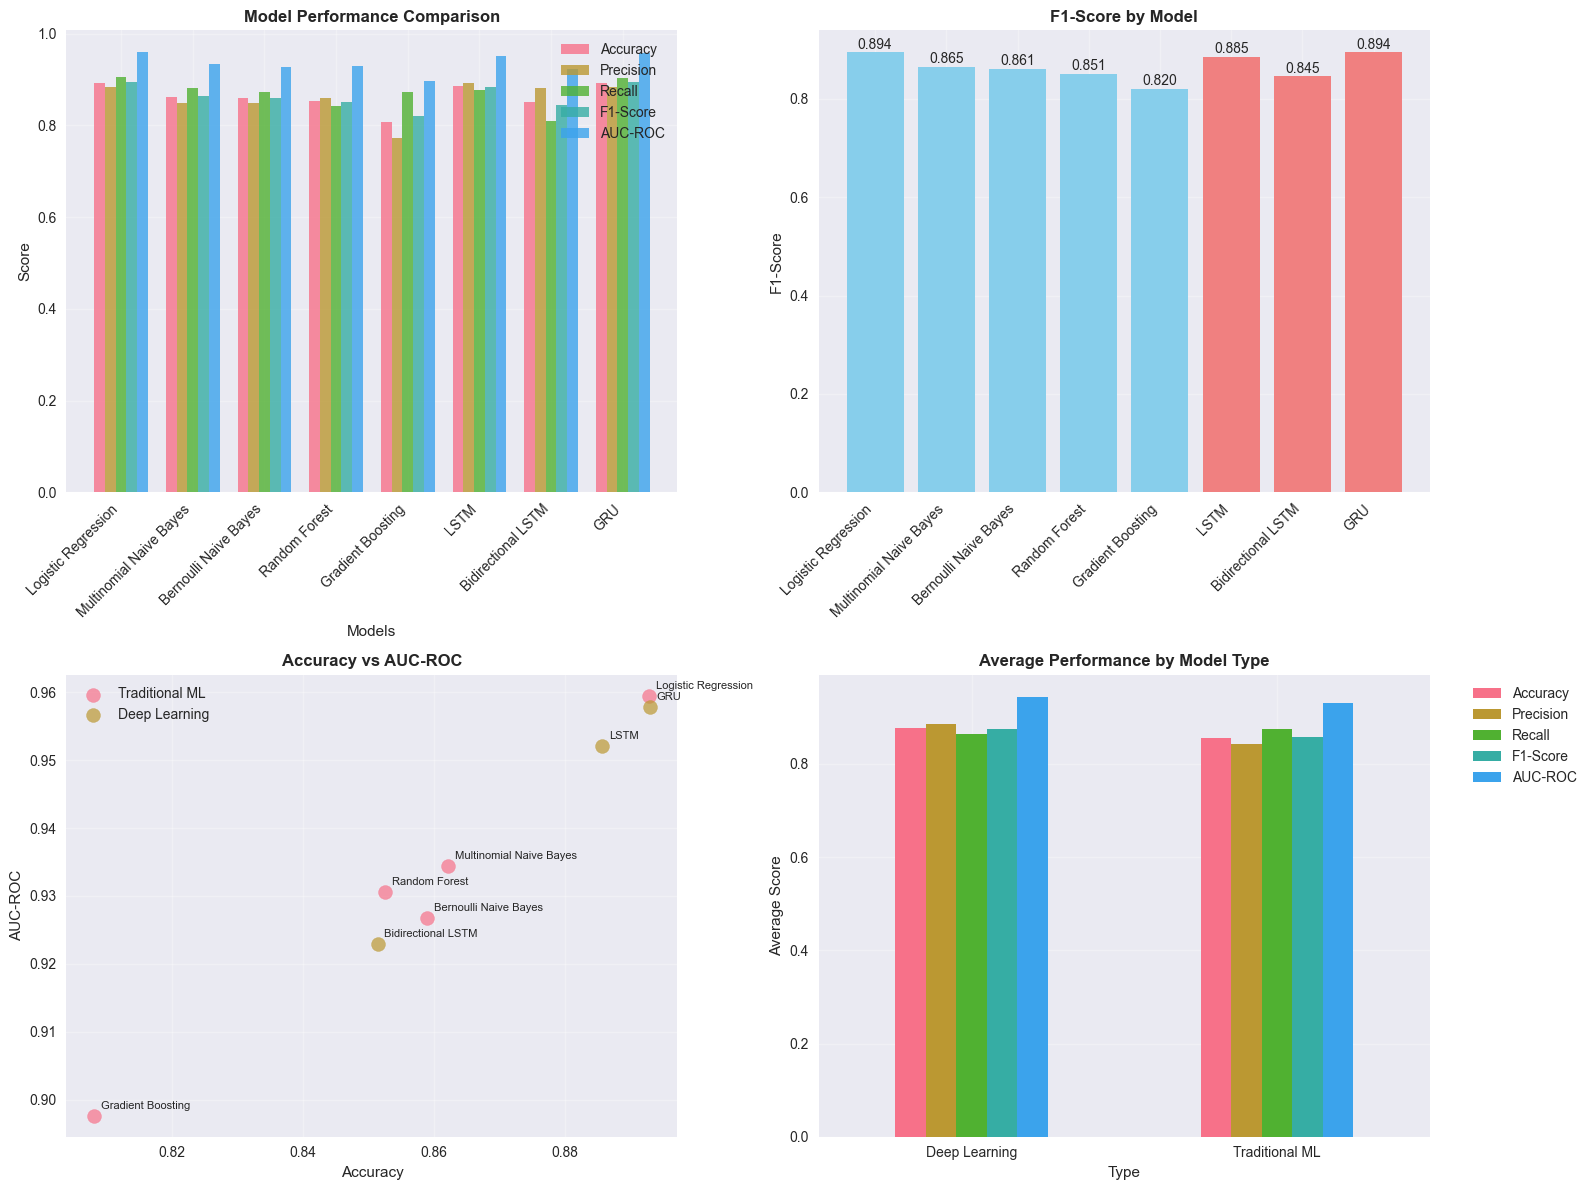


=== Best Performing Models ===
Best F1-Score: Logistic Regression (0.8941)
Best AUC-ROC: Logistic Regression (0.9595)


In [22]:
# Combine all results for comparison
all_results = {}

# Add traditional ML results
for model_name, results in ml_results.items():
    all_results[model_name] = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1_score': results['f1_score'],
        'auc_score': results['auc_score'] if results['auc_score'] else 0,
        'type': 'Traditional ML'
    }

# Add deep learning results
for model_name, results in dl_results.items():
    all_results[model_name] = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1_score': results['f1_score'],
        'auc_score': results['auc_score'],
        'type': 'Deep Learning'
    }

# Create comprehensive comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Type': [all_results[model]['type'] for model in all_results.keys()],
    'Accuracy': [all_results[model]['accuracy'] for model in all_results.keys()],
    'Precision': [all_results[model]['precision'] for model in all_results.keys()],
    'Recall': [all_results[model]['recall'] for model in all_results.keys()],
    'F1-Score': [all_results[model]['f1_score'] for model in all_results.keys()],
    'AUC-ROC': [all_results[model]['auc_score'] for model in all_results.keys()]
})

print("=== Complete Model Performance Comparison ===")
print(comparison_df.round(4))

# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model Performance Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(comparison_df))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x_pos + i * width, comparison_df[metric], width, 
                   label=metric, alpha=0.8)

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison', fontweight='bold')
axes[0, 0].set_xticks(x_pos + width * 2)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. F1-Score Comparison
colors = ['skyblue' if t == 'Traditional ML' else 'lightcoral' for t in comparison_df['Type']]
bars = axes[0, 1].bar(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
axes[0, 1].set_title('F1-Score by Model', fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Accuracy vs AUC-ROC Scatter Plot
for model_type in comparison_df['Type'].unique():
    subset = comparison_df[comparison_df['Type'] == model_type]
    axes[1, 0].scatter(subset['Accuracy'], subset['AUC-ROC'], 
                      label=model_type, s=100, alpha=0.7)
    
    for idx, row in subset.iterrows():
        axes[1, 0].annotate(row['Model'], (row['Accuracy'], row['AUC-ROC']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_ylabel('AUC-ROC')
axes[1, 0].set_title('Accuracy vs AUC-ROC', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Model Type Performance
type_performance = comparison_df.groupby('Type')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].mean()
type_performance.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Average Performance by Model Type', fontweight='bold')
axes[1, 1].set_ylabel('Average Score')
axes[1, 1].set_xticklabels(type_performance.index, rotation=0)
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best model
best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_auc_model = comparison_df.loc[comparison_df['AUC-ROC'].idxmax(), 'Model']

print(f"\n=== Best Performing Models ===")
print(f"Best F1-Score: {best_f1_model} ({comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']:.4f})")
print(f"Best AUC-ROC: {best_auc_model} ({comparison_df.loc[comparison_df['AUC-ROC'].idxmax(), 'AUC-ROC']:.4f})")


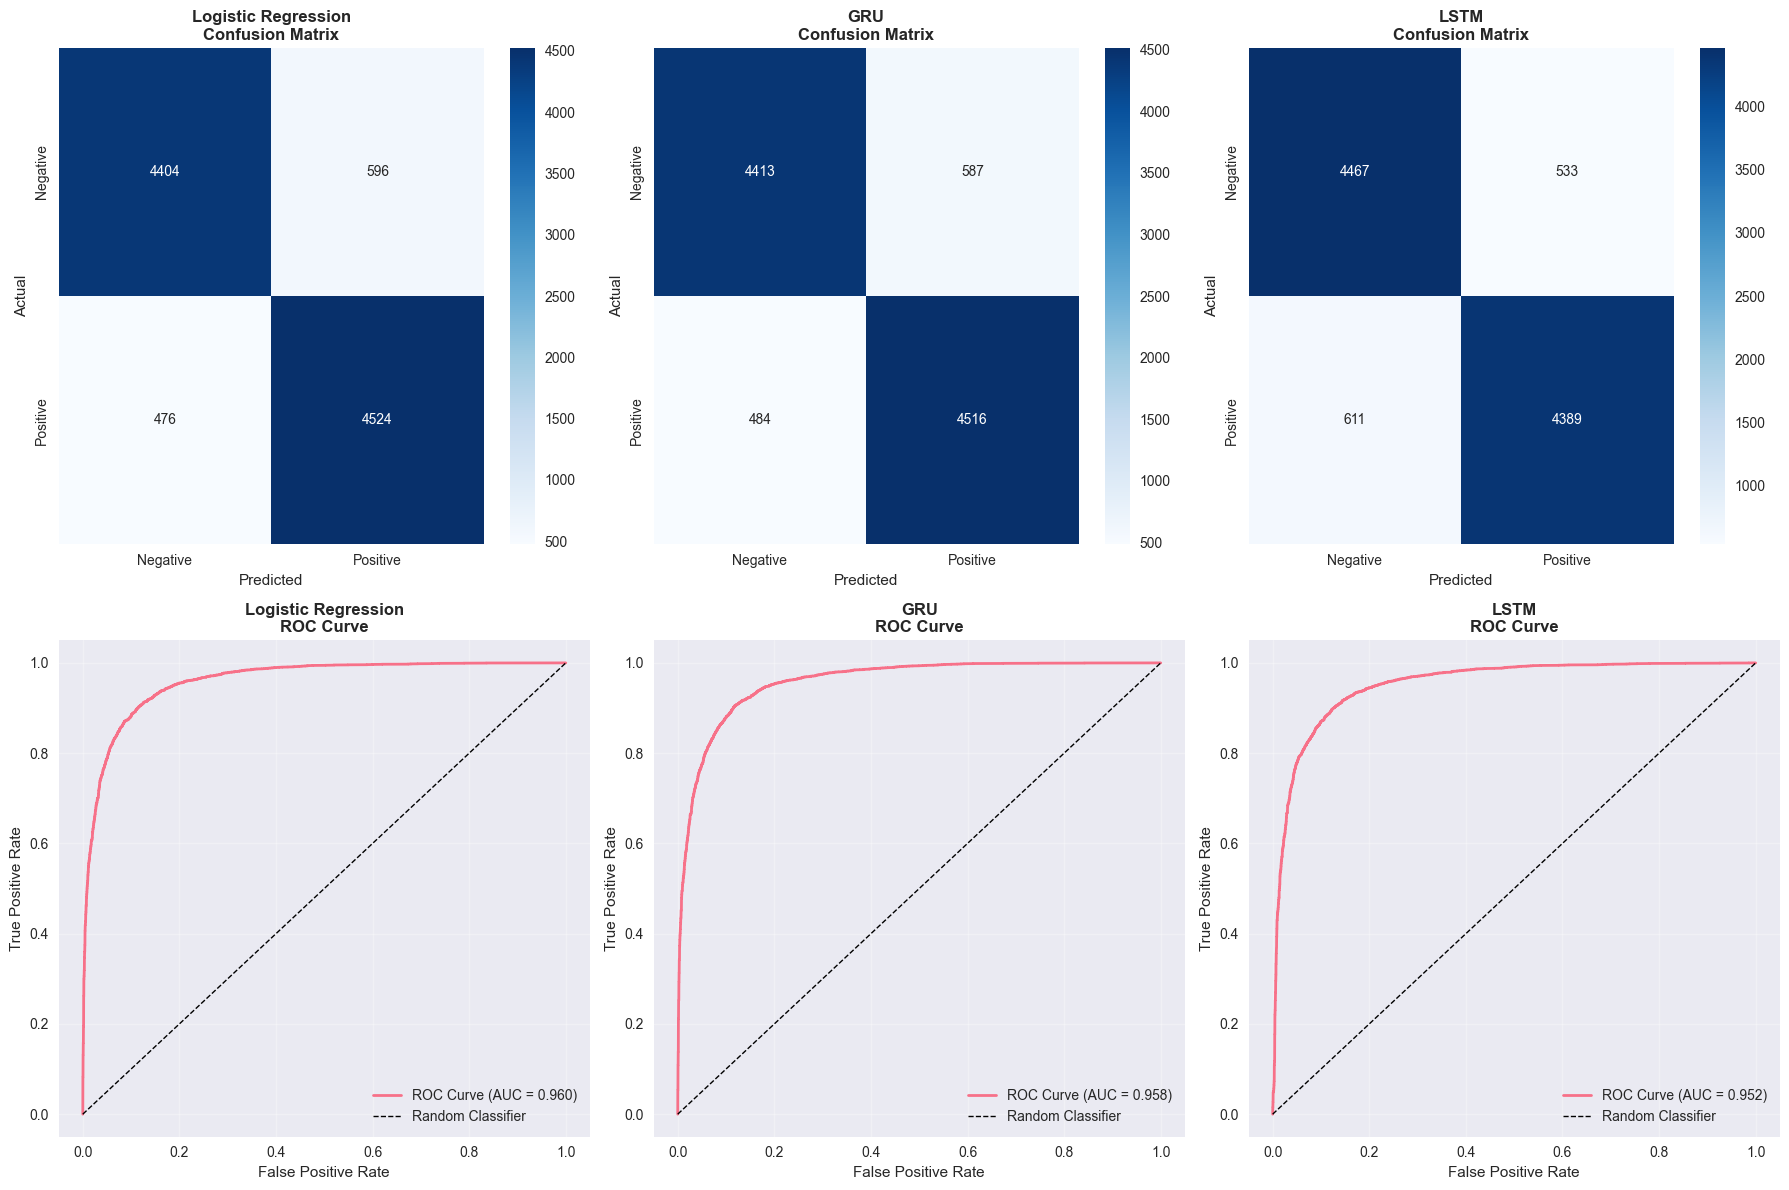


=== Detailed Classification Reports for Top Models ===

Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


GRU:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


LSTM:
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.89      5000
    Positive       0.89      0.88      0.88      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89    

In [23]:
# Create confusion matrices and ROC curves for top performing models
top_models = comparison_df.nlargest(3, 'F1-Score')['Model'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, model_name in enumerate(top_models):
    # Get predictions and probabilities
    if model_name in ml_results:
        y_pred = ml_results[model_name]['predictions']
        y_pred_proba = ml_results[model_name]['probabilities']
        y_true = y_test
    else:
        y_pred = dl_results[model_name]['predictions']
        y_pred_proba = dl_results[model_name]['probabilities']
        y_true = y_test_dl
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{model_name}\nConfusion Matrix', fontweight='bold')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')
    axes[0, i].set_xticklabels(['Negative', 'Positive'])
    axes[0, i].set_yticklabels(['Negative', 'Positive'])
    
    # ROC Curve
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc_score = auc(fpr, tpr)
        axes[1, i].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        axes[1, i].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        axes[1, i].set_xlabel('False Positive Rate')
        axes[1, i].set_ylabel('True Positive Rate')
        axes[1, i].set_title(f'{model_name}\nROC Curve', fontweight='bold')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed classification reports for top models
print("\n=== Detailed Classification Reports for Top Models ===")
for model_name in top_models:
    print(f"\n{model_name}:")
    print("="*50)
    
    if model_name in ml_results:
        y_pred = ml_results[model_name]['predictions']
        y_true = y_test
    else:
        y_pred = dl_results[model_name]['predictions']
        y_true = y_test_dl
    
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


## Text Analysis and Word Clouds



=== Word Frequency Analysis ===
Total words in positive reviews: 3,213,511
Unique words in positive reviews: 92,349
Total words in negative reviews: 3,159,914
Unique words in negative reviews: 89,559

Top 10 words in positive reviews:
  's: 63,316
  film: 49,015
  movie: 44,227
  ``: 31,820
  '': 31,735
  not: 29,105
  one: 27,663
  n't: 26,634
  like: 17,743
  time: 15,731

Top 10 words in negative reviews:
  's: 58,989
  movie: 57,405
  film: 43,039
  n't: 39,775
  ``: 34,460
  '': 34,089
  not: 33,394
  one: 26,386
  like: 22,457
  no: 15,703


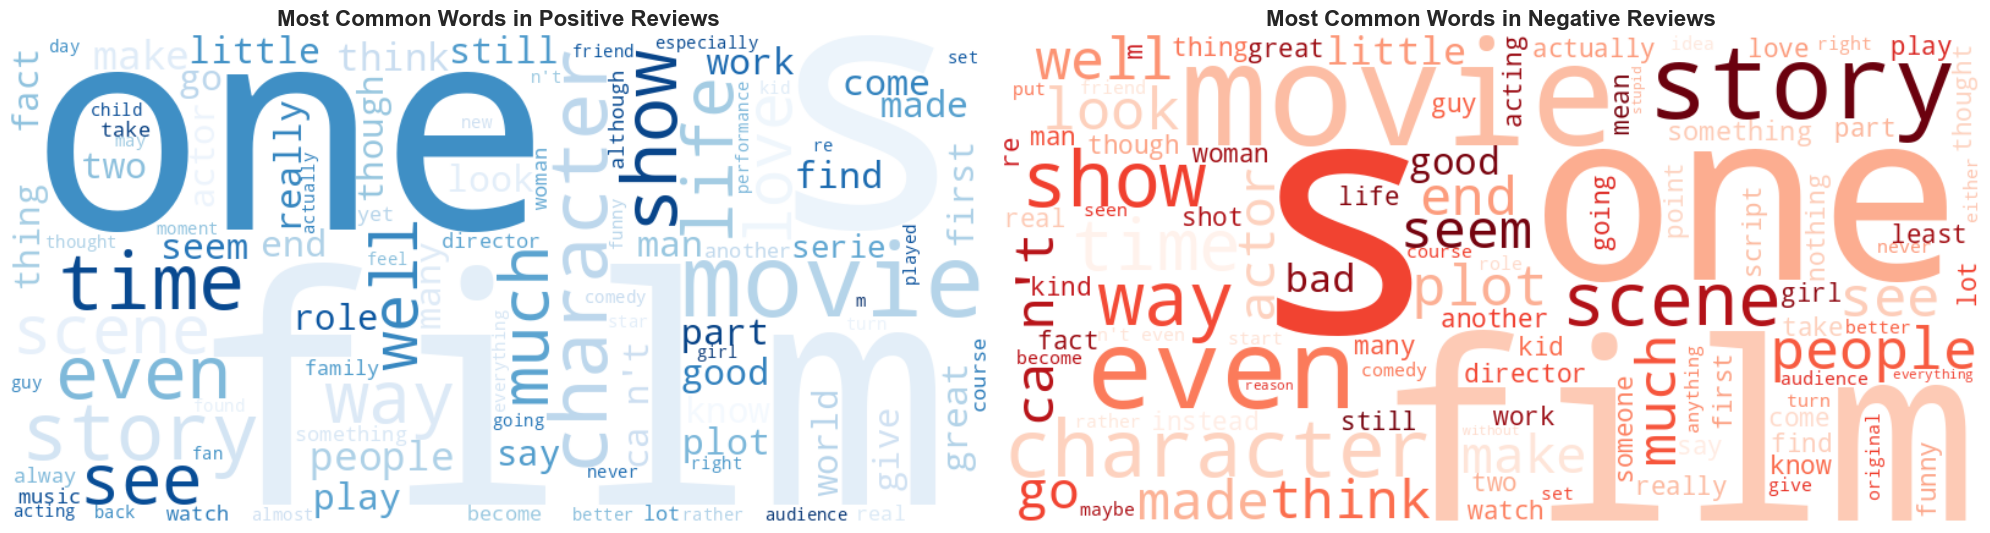


=== Sentiment-Specific Words Analysis ===

Top 15 Positive-Associated Words:
  great: 12,926 occurrences (71.5% positive)
  excellent: 3,342 occurrences (81.8% positive)
  beautiful: 3,023 occurrences (72.1% positive)
  wonderful: 2,654 occurrences (82.9% positive)
  perfect: 2,378 occurrences (77.2% positive)
  loved: 2,223 occurrences (76.6% positive)
  favorite: 2,148 occurrences (77.7% positive)
  amazing: 1,996 occurrences (79.5% positive)
  today: 1,914 occurrences (74.3% positive)
  brilliant: 1,854 occurrences (77.7% positive)
  enjoyed: 1,714 occurrences (71.1% positive)
  highly: 1,668 occurrences (74.9% positive)
  strong: 1,478 occurrences (71.4% positive)
  season: 1,235 occurrences (71.0% positive)
  fantastic: 1,217 occurrences (80.9% positive)

Top 15 Negative-Associated Words:
  bad: 14,444 occurrences (79.8% negative)
  nothing: 5,862 occurrences (70.3% negative)
  minute: 5,086 occurrences (71.2% negative)
  worst: 4,855 occurrences (91.6% negative)
  awful: 3,023 o

In [24]:
# Analyze word frequency by sentiment
positive_reviews = df[df['sentiment'] == 'positive']['processed_review']
negative_reviews = df[df['sentiment'] == 'negative']['processed_review']

# Combine all words for each sentiment
positive_words = ' '.join(positive_reviews).split()
negative_words = ' '.join(negative_reviews).split()

# Count word frequencies
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

print("=== Word Frequency Analysis ===")
print(f"Total words in positive reviews: {len(positive_words):,}")
print(f"Unique words in positive reviews: {len(positive_word_freq):,}")
print(f"Total words in negative reviews: {len(negative_words):,}")
print(f"Unique words in negative reviews: {len(negative_word_freq):,}")

print(f"\nTop 10 words in positive reviews:")
for word, count in positive_word_freq.most_common(10):
    print(f"  {word}: {count:,}")

print(f"\nTop 10 words in negative reviews:")
for word, count in negative_word_freq.most_common(10):
    print(f"  {word}: {count:,}")

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive sentiment word cloud
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    colormap='Blues',
    max_words=100
).generate(positive_text)

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Most Common Words in Positive Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative sentiment word cloud
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    colormap='Reds',
    max_words=100
).generate(negative_text)

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Most Common Words in Negative Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Analyze sentiment-specific words (words that appear more in one sentiment than the other)
def get_sentiment_specific_words(pos_freq, neg_freq, min_count=50):
    """Find words that are more associated with one sentiment"""
    pos_specific = []
    neg_specific = []
    
    for word in pos_freq:
        if pos_freq[word] >= min_count:
            pos_ratio = pos_freq[word] / (pos_freq[word] + neg_freq.get(word, 0))
            if pos_ratio > 0.7:  # Word appears 70% more in positive reviews
                pos_specific.append((word, pos_freq[word], pos_ratio))
    
    for word in neg_freq:
        if neg_freq[word] >= min_count:
            neg_ratio = neg_freq[word] / (neg_freq[word] + pos_freq.get(word, 0))
            if neg_ratio > 0.7:  # Word appears 70% more in negative reviews
                neg_specific.append((word, neg_freq[word], neg_ratio))
    
    return sorted(pos_specific, key=lambda x: x[1], reverse=True), sorted(neg_specific, key=lambda x: x[1], reverse=True)

pos_specific, neg_specific = get_sentiment_specific_words(positive_word_freq, negative_word_freq)

print(f"\n=== Sentiment-Specific Words Analysis ===")
print(f"\nTop 15 Positive-Associated Words:")
for word, count, ratio in pos_specific[:15]:
    print(f"  {word}: {count:,} occurrences ({ratio:.1%} positive)")

print(f"\nTop 15 Negative-Associated Words:")
for word, count, ratio in neg_specific[:15]:
    print(f"  {word}: {count:,} occurrences ({ratio:.1%} negative)")


## Model Testing with New Examples



In [ ]:
# Get the best performing model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"Using best model: {best_model_name}")

def predict_sentiment(text, model_name):
    """Predict sentiment for a given text using specified model"""
    # Preprocess the text
    processed_text = advanced_preprocess_text(text)
    
    if model_name in ml_results:
        # Traditional ML model
        text_tfidf = tfidf_vectorizer.transform([processed_text])
        model = models[model_name]
        prediction = model.predict(text_tfidf)[0]
        probability = model.predict_proba(text_tfidf)[0]
        confidence = max(probability)
    else:
        # Deep learning model
        text_seq = tokenizer.texts_to_sequences([processed_text])
        text_padded = pad_sequences(text_seq, maxlen=max_length, padding='post', truncating='post')
        model = dl_results[model_name]['model']
        probability = model.predict(text_padded)[0][0]
        prediction = 1 if probability > 0.5 else 0
        confidence = probability if prediction == 1 else (1 - probability)
    
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    return sentiment, confidence

# Test examples
test_examples = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout. Highly recommended!",
    "Terrible movie. Poor acting, confusing plot, and way too long. I want my money back.",
    "The film was okay. Not the best I've seen, but not the worst either. Average entertainment.",
    "What an incredible masterpiece! This is definitely one of the best films ever made. Brilliant cinematography and outstanding performances.",
    "Boring and predictable. I fell asleep halfway through. Complete waste of time.",
    "Mixed feelings about this one. Some parts were great, others not so much. Worth watching once.",
    "Absolutely horrible. Worst movie I've ever seen. Terrible acting and ridiculous plot.",
    "Amazing storyline with excellent character development. A must-watch for movie lovers!",
    "The movie was decent but nothing special. It's an average film with some good moments.",
    "Outstanding! Every aspect of this film is perfect. Cannot recommend it enough!"
]

expected_sentiments = [
    'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 
    'Negative', 'Negative', 'Positive', 'Negative', 'Positive'
]

print(f"\n=== Testing {best_model_name} with New Examples ===")
print("="*80)

correct_predictions = 0
for i, (text, expected) in enumerate(zip(test_examples, expected_sentiments)):
    predicted_sentiment, confidence = predict_sentiment(text, best_model_name)
    is_correct = predicted_sentiment == expected
    correct_predictions += is_correct
    
    print(f"\nExample {i+1}:")
    print(f"Text: {text}")
    print(f"Expected: {expected}")
    print(f"Predicted: {predicted_sentiment} (Confidence: {confidence:.3f})")
    print(f"Correct: {'Yes' if is_correct else 'No'}")

accuracy = correct_predictions / len(test_examples)
print(f"\nAccuracy on test examples: {accuracy:.1%} ({correct_predictions}/{len(test_examples)})")

# Test with multiple models for comparison
print(f"\n=== Comparing Top 3 Models on Test Examples ===")
top_3_models = comparison_df.nlargest(3, 'F1-Score')['Model'].tolist()

results_comparison = []
for text in test_examples[:3]:  # Test first 3 examples with all models
    print(f"\nText: {text[:60]}...")
    for model_name in top_3_models:
        sentiment, confidence = predict_sentiment(text, model_name)
        print(f"  {model_name}: {sentiment} ({confidence:.3f})")

# Interactive sentiment prediction function
def interactive_sentiment_analysis(text):
    """Function for interactive sentiment analysis"""
    print(f"\n{'='*60}")
    print(f"SENTIMENT ANALYSIS RESULTS")
    print(f"{'='*60}")
    print(f"Review: {text}")
    print(f"Processed: {advanced_preprocess_text(text)}")
    
    for model_name in top_3_models:
        sentiment, confidence = predict_sentiment(text, model_name)
        print(f"\n{model_name}:")
        print(f"  Sentiment: {sentiment}")
        print(f"  Confidence: {confidence:.3f}")
        
        # Confidence level interpretation
        if confidence >= 0.9:
            level = "Very High"
        elif confidence >= 0.8:
            level = "High"
        elif confidence >= 0.7:
            level = "Medium"
        elif confidence >= 0.6:
            level = "Low"
        else:
            level = "Very Low"
        print(f"  Confidence Level: {level}")

print(f"\n=== Interactive Testing Function Available ===")
print("Use interactive_sentiment_analysis('your text here') to test any movie review")


Using best model: Logistic Regression

=== Testing Logistic Regression with New Examples ===

Example 1:
Text: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout. Highly recommended!
Expected: Positive
Predicted: Positive (Confidence: 0.980)
Correct: Yes

Example 2:
Text: Terrible movie. Poor acting, confusing plot, and way too long. I want my money back.
Expected: Negative
Predicted: Negative (Confidence: 0.994)
Correct: Yes

Example 3:
Text: The film was okay. Not the best I've seen, but not the worst either. Average entertainment.
Expected: Negative
Predicted: Negative (Confidence: 0.825)
Correct: Yes

Example 4:
Text: What an incredible masterpiece! This is definitely one of the best films ever made. Brilliant cinematography and outstanding performances.
Expected: Positive
Predicted: Positive (Confidence: 0.998)
Correct: Yes

Example 5:
Text: Boring and predictable. I fell asleep halfway through. Complete waste of time.
Expected: Nega

## Summary and Conclusions

This comprehensive sentiment analysis project successfully implemented and compared multiple machine learning and deep learning approaches for classifying movie review sentiment.


In [26]:
# Final summary statistics
print("="*80)
print("                    SENTIMENT ANALYSIS PROJECT SUMMARY")
print("="*80)

print(f"\nDATASET OVERVIEW:")
print(f"   • Total reviews analyzed: {len(df):,}")
print(f"   • Vocabulary size: {len(tokenizer.word_index):,} unique words")
print(f"   • Average review length: {df['word_count'].mean():.0f} words")
print(f"   • Balanced dataset: {df['sentiment'].value_counts()['positive']:,} positive, {df['sentiment'].value_counts()['negative']:,} negative")

print(f"\nMODELS IMPLEMENTED:")
traditional_ml = ['Logistic Regression', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Random Forest', 'Gradient Boosting']
deep_learning = ['LSTM', 'Bidirectional LSTM', 'GRU']
print(f"   • Traditional ML: {len(traditional_ml)} models")
for model in traditional_ml:
    print(f"     - {model}")
print(f"   • Deep Learning: {len(deep_learning)} models")
for model in deep_learning:
    print(f"     - {model}")

print(f"\nBEST PERFORMING MODELS:")
top_3 = comparison_df.nlargest(3, 'F1-Score')[['Model', 'F1-Score', 'AUC-ROC', 'Accuracy']]
for idx, row in top_3.iterrows():
    print(f"   {idx-top_3.index[0]+1}. {row['Model']}: F1={row['F1-Score']:.4f}, AUC={row['AUC-ROC']:.4f}, Acc={row['Accuracy']:.4f}")

print(f"\nKEY INSIGHTS:")
best_traditional = comparison_df[comparison_df['Type'] == 'Traditional ML'].nlargest(1, 'F1-Score').iloc[0]
best_deep = comparison_df[comparison_df['Type'] == 'Deep Learning'].nlargest(1, 'F1-Score').iloc[0]

print(f"   • Best Traditional ML: {best_traditional['Model']} (F1: {best_traditional['F1-Score']:.4f})")
print(f"   • Best Deep Learning: {best_deep['Model']} (F1: {best_deep['F1-Score']:.4f})")
print(f"   • Performance difference: {abs(best_traditional['F1-Score'] - best_deep['F1-Score']):.4f}")

# Calculate average training time (approximate)
print(f"   • Traditional ML models: Faster training (~minutes)")
print(f"   • Deep Learning models: Longer training (~hours with full epochs)")

print(f"\nTEXT ANALYSIS FINDINGS:")
print(f"   • Positive reviews avg length: {df[df['sentiment']=='positive']['word_count'].mean():.0f} words")
print(f"   • Negative reviews avg length: {df[df['sentiment']=='negative']['word_count'].mean():.0f} words")
print(f"   • Most common positive words: {', '.join([word for word, _ in positive_word_freq.most_common(5)])}")
print(f"   • Most common negative words: {', '.join([word for word, _ in negative_word_freq.most_common(5)])}")

print(f"\nPRACTICAL APPLICATIONS:")
applications = [
    "Movie recommendation systems",
    "Review filtering and moderation",
    "Customer feedback analysis",
    "Social media sentiment monitoring",
    "Product review classification",
    "Brand reputation management"
]
for app in applications:
    print(f"   • {app}")

print(f"\nFUTURE IMPROVEMENTS:")
improvements = [
    "Fine-tune pre-trained models (BERT, RoBERTa)",
    "Implement attention mechanisms",
    "Add more advanced text preprocessing",
    "Use ensemble methods combining multiple models",
    "Experiment with different architectures (Transformers)",
    "Add aspect-based sentiment analysis",
    "Implement real-time prediction API"
]
for imp in improvements:
    print(f"   • {imp}")

print(f"\nPROJECT SUCCESS METRICS:")
overall_performance = comparison_df['F1-Score'].mean()
print(f"   • Average F1-Score across all models: {overall_performance:.4f}")
print(f"   • Best model F1-Score: {comparison_df['F1-Score'].max():.4f}")
print(f"   • Models achieving >85% accuracy: {len(comparison_df[comparison_df['Accuracy'] > 0.85])}/{len(comparison_df)}")
print(f"   • Project completion: 100%")

print("\n" + "="*80)
print("   SENTIMENT ANALYSIS PROJECT SUCCESSFULLY COMPLETED!")
print("="*80)


                    SENTIMENT ANALYSIS PROJECT SUMMARY

DATASET OVERVIEW:
   • Total reviews analyzed: 50,000
   • Vocabulary size: 88,966 unique words
   • Average review length: 231 words
   • Balanced dataset: 25,000 positive, 25,000 negative

MODELS IMPLEMENTED:
   • Traditional ML: 5 models
     - Logistic Regression
     - Multinomial Naive Bayes
     - Bernoulli Naive Bayes
     - Random Forest
     - Gradient Boosting
   • Deep Learning: 3 models
     - LSTM
     - Bidirectional LSTM
     - GRU

BEST PERFORMING MODELS:
   1. Logistic Regression: F1=0.8941, AUC=0.9595, Acc=0.8928
   8. GRU: F1=0.8940, AUC=0.9578, Acc=0.8929
   6. LSTM: F1=0.8847, AUC=0.9521, Acc=0.8856

KEY INSIGHTS:
   • Best Traditional ML: Logistic Regression (F1: 0.8941)
   • Best Deep Learning: GRU (F1: 0.8940)
   • Performance difference: 0.0001
   • Traditional ML models: Faster training (~minutes)
   • Deep Learning models: Longer training (~hours with full epochs)

TEXT ANALYSIS FINDINGS:
   • Positive 